In [99]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [100]:
# Set up
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# Basics
import tensorflow as tf
import xarray as xr
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_preds import *
from src.models.DRN.DRN_load_preds_dummy_10 import *
from src.models.EMOS_local.EMOS_local_load_preds import *  # Load EMOS_global_preds
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_preds import *  # Load EMOS_global_preds
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

<IPython.core.display.Javascript object>

### 1. Load Predictions:

In [101]:
# EMOS_global
EMOS_global_t2m_preds = EMOS_global_load_preds("t2m")
EMOS_global_ws10_preds = EMOS_global_load_preds("ws10")

# EMOS_global
EMOS_local_t2m_preds = EMOS_local_load_preds("t2m")
EMOS_local_ws10_preds = EMOS_local_load_preds("ws10")

# EMOS_global
DRN_t2m_preds = DRN_load_preds_dummy_10("t2m")
DRN_ws10_preds = DRN_load_preds_dummy_10("ws10")

<IPython.core.display.Javascript object>

### 2. Load Matching Ground truth values 

In [102]:
t2m_ground_truth = ldpd.load_data_all_test_proc_denorm()[2].t2m_test_truth
ws10_ground_truth = ldpd.load_data_all_test_proc_denorm()[5].ws10_test_truth

<IPython.core.display.Javascript object>

### Function

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import norm


def plot_pit_histogram(predicted_mean_sd, ground_truth, title, num_bins=50):
    assert isinstance(predicted_mean_sd, list)
    assert isinstance(ground_truth, xr.DataArray)
    assert all(isinstance(arr, np.ndarray) for arr in predicted_mean_sd)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    max_frequency = 0

    # Set bar width to 90% of the bin width
    bar_width = 0.9 / num_bins

    for lead_time_idx, mean_sd_array in enumerate(predicted_mean_sd):
        mean_array = np.abs(mean_sd_array[..., 0])
        sd_array = np.abs(mean_sd_array[..., 1])
        ground_truth_data = ground_truth.sel(lead_time=(lead_time_idx + 1))

        pits = norm.cdf(ground_truth_data.values, loc=mean_array, scale=sd_array)

        # Use numpy.histogram to calculate histogram values and bin edges
        hist, bin_edges = np.histogram(
            pits.flatten(), bins=np.linspace(0, 1, num_bins + 1), density=False,
        )

        # Normalize the histogram
        hist = hist / hist.sum()

        # Update the maximum frequency if necessary
        max_frequency = max(0, hist.max())

        # Plot the histogram as a 3D bar plot
        xs = bin_edges[:-1]
        ys = hist
        zs = np.full_like(
            xs, (lead_time_idx + 1) * 6
        )  # Create an array with lead time index repeated for each bin
        ax.bar(xs, ys, zs=zs, zdir="y", alpha=1, width=bar_width)

    ax.set_xlabel("PIT")
    ax.set_ylabel("Lead Time in hours")
    ax.set_zlabel("Frequency")
    ax.set_title(title)
    ax.set_zlim(0, max_frequency)

    title_list = title.split()
    plt.savefig(
        f"/home/dchen/BA_CH_EN/reports/figures/{title_list[0]}_PIT_histogram_3D_{title_list[-1]}.pdf"
    )

    plt.show()

<IPython.core.display.Javascript object>

### 1. EMOS_global

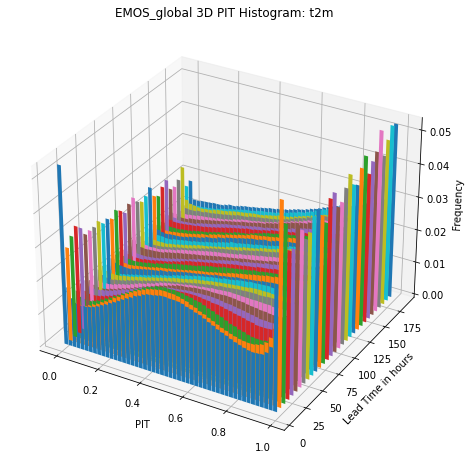

<IPython.core.display.Javascript object>

In [106]:
plot_pit_histogram(
    EMOS_global_t2m_preds, t2m_ground_truth, "EMOS_global 3D PIT Histogram: t2m"
)

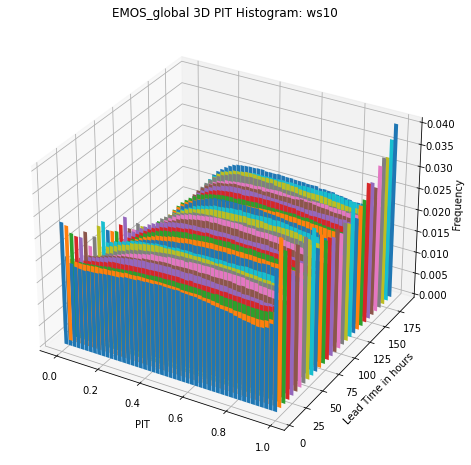

<IPython.core.display.Javascript object>

In [117]:
plot_pit_histogram(
    EMOS_global_ws10_preds, ws10_ground_truth, "EMOS_global 3D PIT Histogram: ws10"
)

### 2. EMOS_local

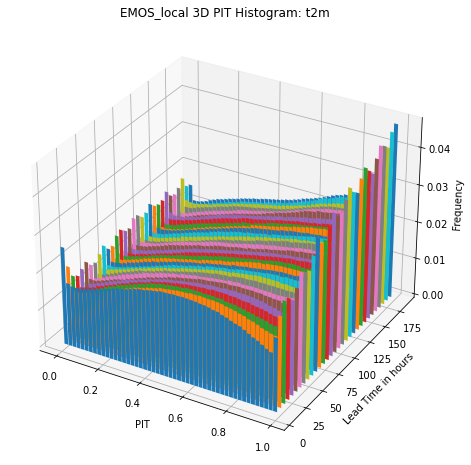

<IPython.core.display.Javascript object>

In [108]:
plot_pit_histogram(
    EMOS_local_t2m_preds, t2m_ground_truth, "EMOS_local 3D PIT Histogram: t2m"
)

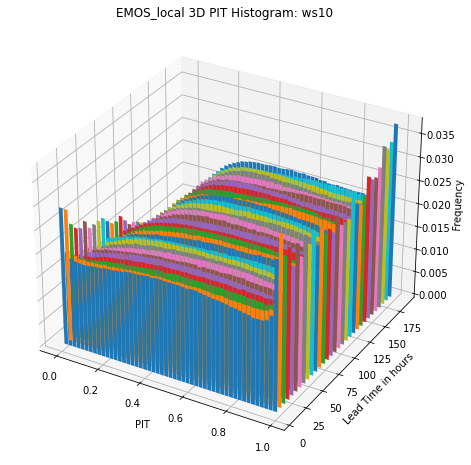

<IPython.core.display.Javascript object>

In [118]:
plot_pit_histogram(
    EMOS_local_ws10_preds, ws10_ground_truth, "EMOS_local 3D PIT Histogram: ws10"
)

### 3. DRN

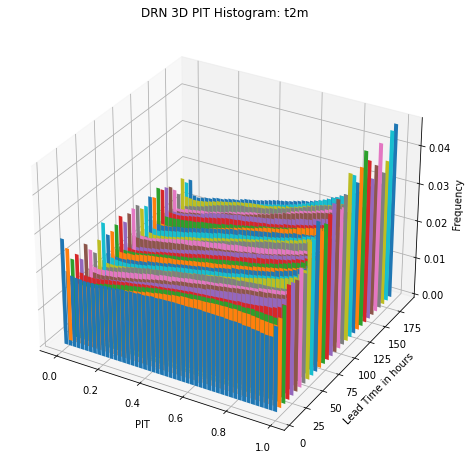

<IPython.core.display.Javascript object>

In [110]:
plot_pit_histogram(DRN_t2m_preds, t2m_ground_truth, "DRN 3D PIT Histogram: t2m")

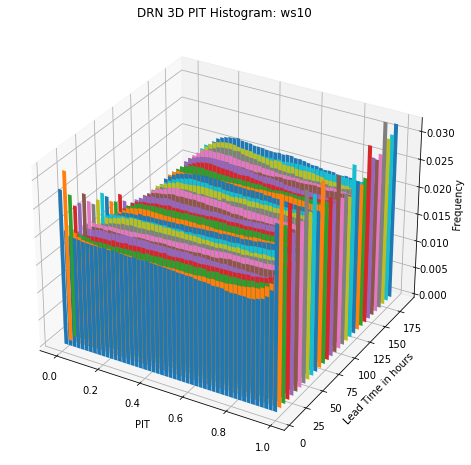

<IPython.core.display.Javascript object>

In [111]:
plot_pit_histogram(DRN_ws10_preds, ws10_ground_truth, "DRN 3D PIT Histogram: ws10")